In [1]:
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)

from src.helpers import helper_functions, load_data, visuals

In [2]:
plt.rcParams["figure.figsize"] = (15, 6)
plt.style.use("ggplot")
plt.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=["#1f77b4", "red"])

In [3]:
df_housing_raw = load_data.load_housing_raw_data()

In [4]:
project_path = helper_functions.get_project_path()

# Plan
1. splitting train-test
2. exploring data
3. data preparation pipeline (cleaning, imputing, feature engineering)
4. hyperparameter tuning
5. overfitting/underfitting check
6. evaluation on testing data

# Quick EDA to know how to stratify and split the data into train/test

When splitting our data, we want to make sure the training set is representative of the cases we want to generalize to. Otherwise, we would train machine learning models that would not make accurate predictions.
That is why we need to make sure the distribution of key features correlated to our target are preserved in the test set. By doing so, we are evaluating our machine learning models against representative data and hence, we can trust the quality of our models' predictions.

Splitting the data in this manner is called _stratified sampling_. To do so, we need to do some basic exploratory of our data. This is what we will do now.

In [5]:
df_housing_raw.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

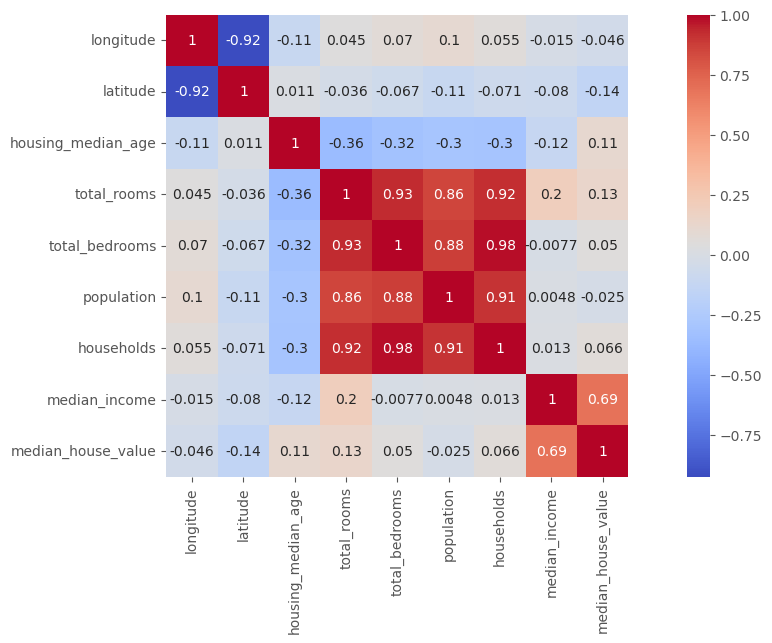

In [6]:
visuals.plot_correlation(df_housing_raw)

2 insights from the correlation plot:
- the median_house_value (target) is quite correlated to the median_income, so we will use it to split the data (in a stratified manner)
- total_bedrooms has 207 missing values and is very correlated to households, so we will use it to fill the missing values with a customer sklearn transformer

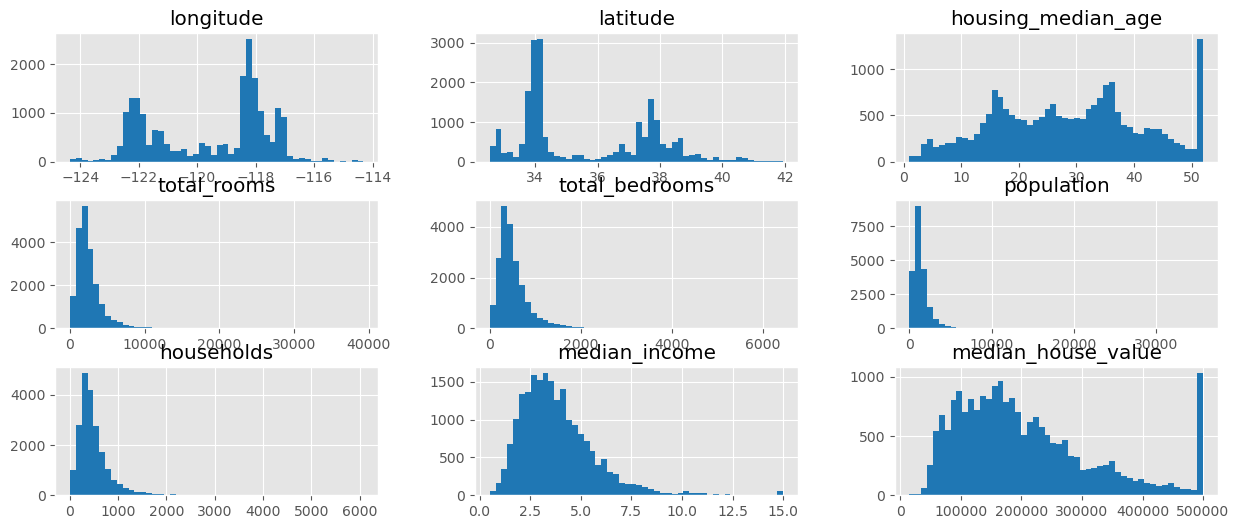

In [7]:
df_housing_raw.hist(bins=50)
plt.savefig(project_path / "images" / "features_histogram.png")

In [8]:
df_housing = df_housing_raw.copy()

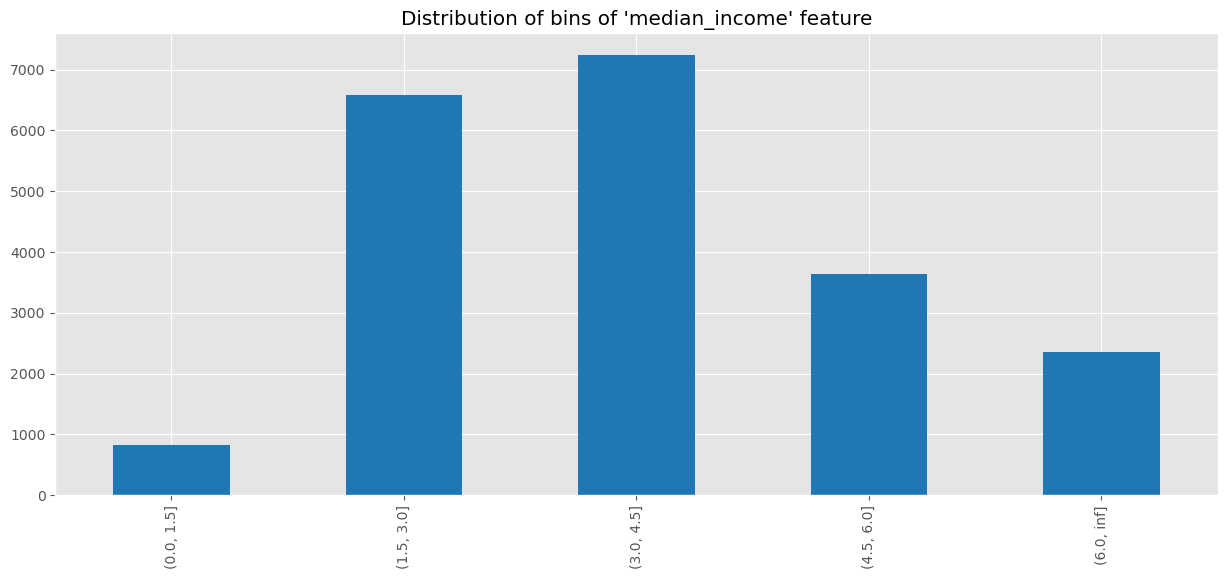

In [9]:
fig, ax = plt.subplots()
pd.cut(
    df_housing["median_income"], bins=[0, 1.5, 3, 4.5, 6, np.inf]
).value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Distribution of bins of 'median_income' feature")
plt.savefig(project_path / "images" / "dist_bin_median_income.png")

# Split into train/test data

In [10]:
df_housing["median_income_bin"] = pd.cut(
    df_housing["median_income"],
    bins=[0, 1.5, 3, 4.5, 6, np.inf],
    labels=[1, 2, 3, 4, 5],
)

In [11]:
df_train, df_test = train_test_split(
    df_housing,
    test_size=0.2,
    random_state=42,
    stratify=df_housing["median_income_bin"],
)

# More EDA (training set only)

In [12]:
# fig = px.scatter_geo(df_train, lat='latitude', lon='longitude', color='median_house_value', fitbounds='locations', size='median_house_value')
# fig.write_html(project_path / 'images/median_house_value_geospatial.html')

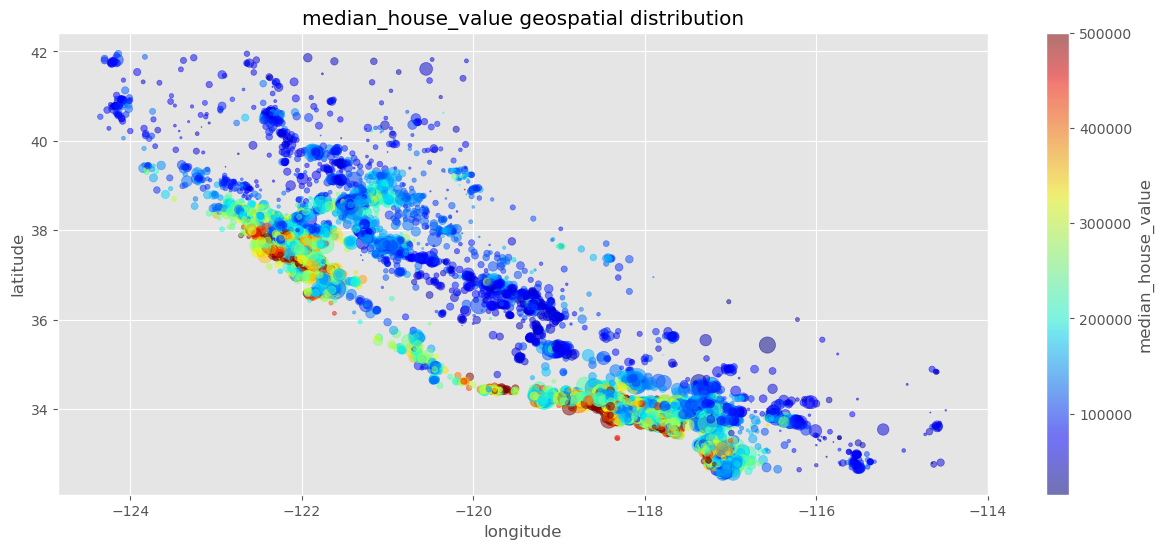

In [13]:
fig, ax = plt.subplots()
df_train.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    s=df_train["population"] / 50,
    c="median_house_value",
    cmap="jet",
    ax=ax,
    alpha=0.5,
    title="median_house_value geospatial distribution",
)
plt.savefig(project_path / "images/median_house_value_geospatial.png")

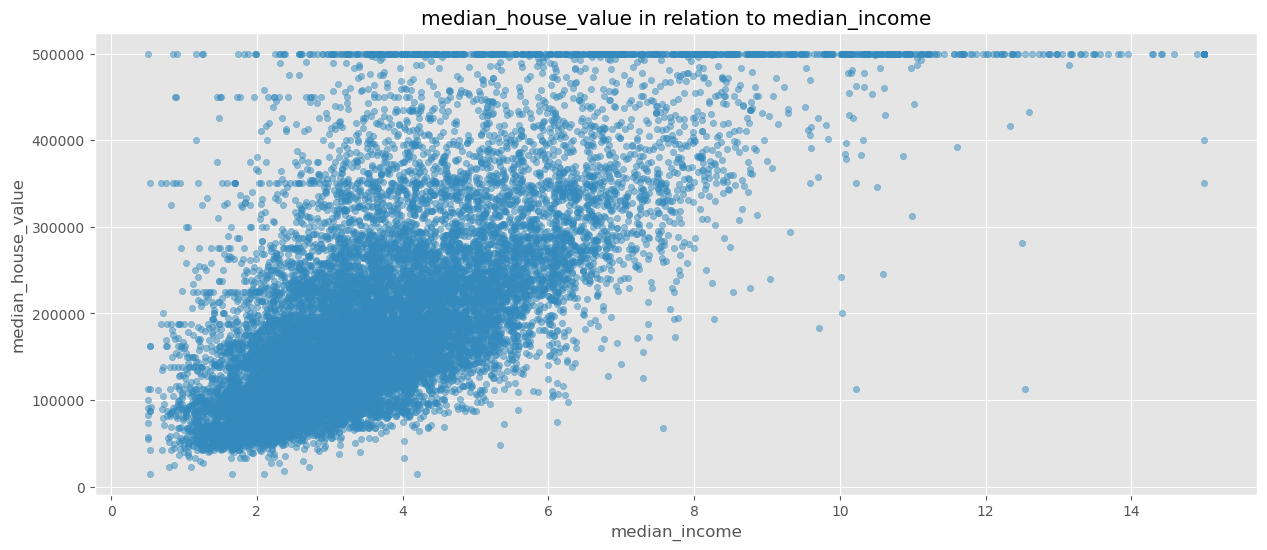

In [14]:
fig, ax = plt.subplots()
df_train.plot(
    kind="scatter",
    x="median_income",
    y="median_house_value",
    alpha=0.5,
    title="median_house_value in relation to median_income",
    ax=ax,
)
plt.savefig(project_path / "images/house_value_vs_income.png")

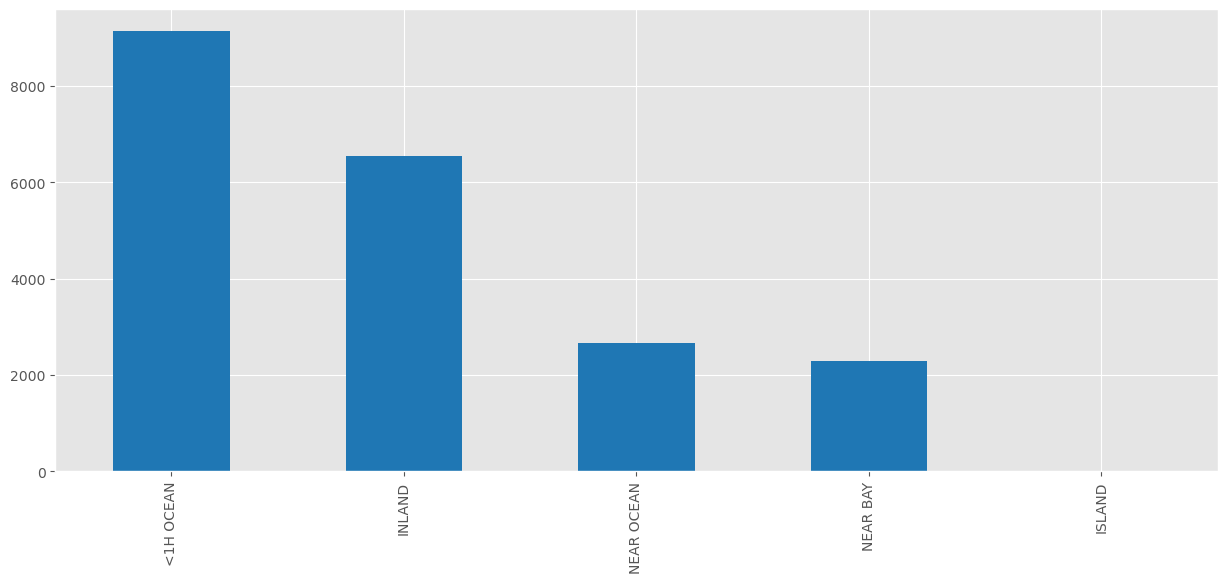

In [15]:
df_housing.ocean_proximity.value_counts().plot(kind="bar");

In [16]:
df_housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
median_income_bin       0
dtype: int64

Text(0.5, 1.0, "Distribution of bins of 'households' feature")

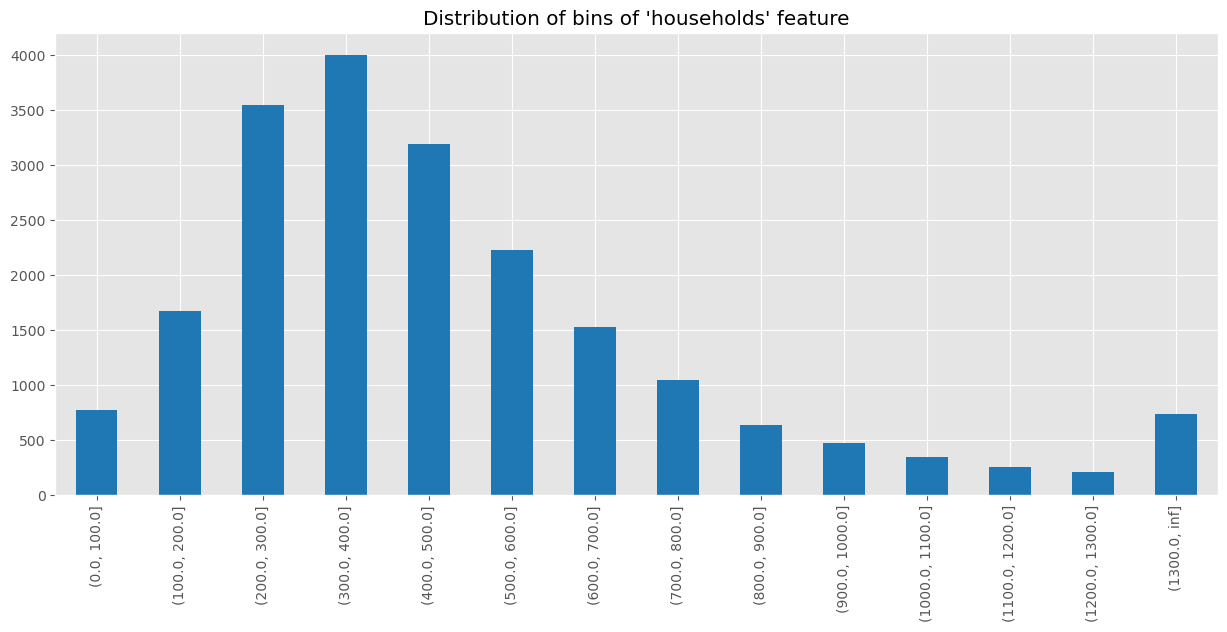

In [17]:
# plot distribution of households with annotation of values for each bin
fig, ax = plt.subplots()
pd.cut(
    df_housing["households"], bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, np.inf]
).value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Distribution of bins of 'households' feature")

In [18]:
# create a new column equal to total_bedrooms
df_housing['total_bedrooms_fill_nan'] = df_housing['total_bedrooms']

# create a new column with adequate bin households
df_housing['households_bin'] = pd.cut(df_housing['households'], bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, np.inf], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

# fill missing values of total_bedrooms_fill_nan with the median of grouped households_bin
df_housing['total_bedrooms_fill_nan'] = df_housing.groupby('households_bin')['total_bedrooms'].transform(lambda x: x.fillna(x.median()))


In [19]:

# show the dataframe where total_bedrooms is missing
df_housing.loc[df_housing["total_bedrooms"].isna(), ["total_bedrooms", "households", "total_bedrooms_fill_nan"]].head(20)

,total_bedrooms,households,total_bedrooms_fill_nan
182,NaN,682,682.0
327,NaN,611,682.0
366,NaN,354,365.0
477,NaN,474,470.0
495,NaN,158,174.0
504,NaN,269,269.0
1009,NaN,106,174.0
1271,NaN,347,365.0
1343,NaN,112,174.0
1441,NaN,715,790.0


In [20]:
map_test = df_housing.groupby("households_bin")["total_bedrooms"].mean()
map_test

households_bin
1       76.307292
2      185.686405
3      274.835519
4      371.466281
5      478.359696
6      584.358148
7      690.068167
8      797.734043
9      908.285714
10    1025.791845
11    1619.723572
Name: total_bedrooms, dtype: float64

In [21]:
df_housing["test_map"] = df_housing["households_bin"].map(map_test)
df_housing.loc[df_housing["test_map"].notna()]



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_bin,total_bedrooms_fill_nan,households_bin,test_map
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY,5,129.0,2,185.686405
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY,5,1106.0,11,1619.723572
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY,5,190.0,2,185.686405
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY,4,235.0,3,274.835519
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY,3,280.0,3,274.835519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,INLAND,2,374.0,4,371.466281
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,INLAND,2,150.0,2,185.686405
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,INLAND,2,485.0,5,478.359696
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,INLAND,2,409.0,4,371.466281


In [22]:
a = df_housing["total_bedrooms"].map(map_test).reset_index()
a.loc[a["total_bedrooms"].notnull()]

,index,total_bedrooms
73,73,371.466281
301,301,690.068167
1006,1006,371.466281
1194,1194,1619.723572
1235,1235,584.358148
...,...,...
19231,19231,908.285714
19779,19779,797.734043
19802,19802,1025.791845
19901,19901,478.359696


In [23]:
# custom imputer in scikit-learn that fill missing values of a column with its median or mean by groups of households_bin


In [24]:
# custom imputer in scikit-learn that fill missing values of a column with its median or mean by groups of households_bin
class GroupedImputer(SimpleImputer):
    def __init__(self, groupby, target, strategy="median"):
        self.groupby = groupby
        self.target = target
        self.strategy = strategy

    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.imputer.fit(X.groupby(self.groupby)[self.target])
        return self

    def transform(self, X, y=None):
        X[self.target] = X.groupby(self.groupby)[self.target].transform(
            lambda x: x.fillna(self.imputer.statistics_[0])
        )
        return X
    

In [25]:
# custom transformer in scikit-learn that creates n columns corresponding to the n kmeans clusters and calculates the distances to each cluster
class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=5, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans.fit(X)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["kmeans_cluster"] = self.kmeans.predict(X)
        X["kmeans_distance"] = self.kmeans.transform(X).min(axis=1)
        return X

Text(0.5, 1.0, 'total_bedrooms grouped by households')

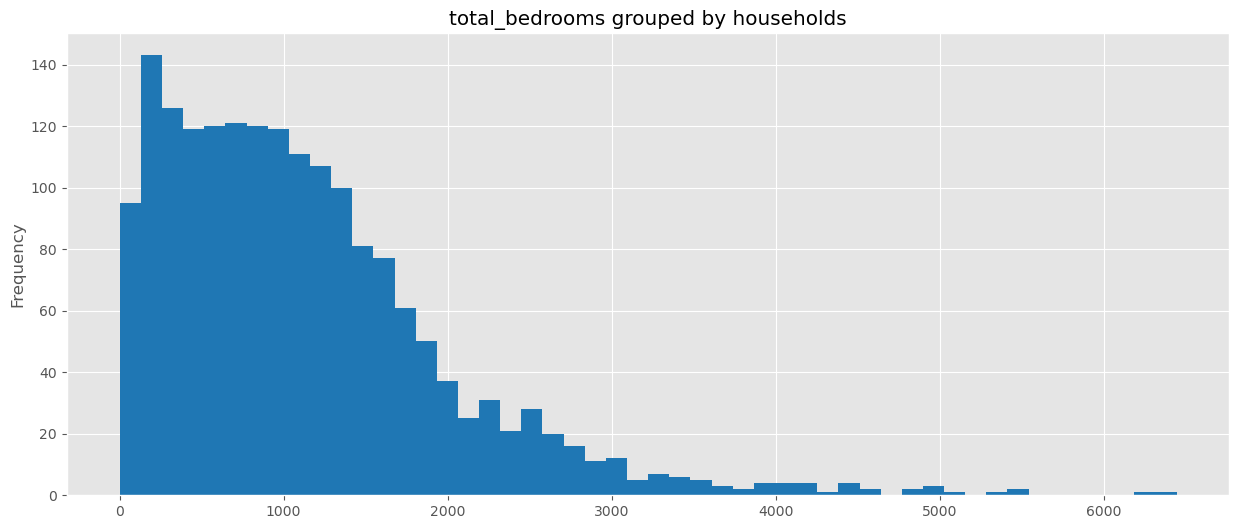

In [26]:
# plot total_bedrooms grouped by households with adequate bins
fig, ax = plt.subplots()
df_housing.groupby("households")["total_bedrooms"].mean().plot(
    kind="hist", bins=50, ax=ax
)
ax.set_title("total_bedrooms grouped by households")
# plt.savefig(project_path / "images" / "total_bedrooms_grouped_by_households.png")


# Feature engineering

In [27]:
df_train_X = df_train.drop("median_house_value", axis=1)
train_y = df_train["median_house_value"]

Let's create a customer imputer for total_bedrooms

In [28]:
# custom imputer in scikit-learn that fill missing values with the median or mean of a grouped target column
class GroupedImputer(BaseEstimator, TransformerMixin):
    def __init__(self, groupby, target, strategy="median"):
        self.groupby = groupby
        self.target = target
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.strategy == "median":
            self.imputer = X.groupby(self.groupby)[self.target].median()
        elif self.strategy == "mean":
            self.imputer = X.groupby(self.groupby)[self.target].mean()
        return self

    def transform(self, X, y=None):
        X[self.target] = X[self.target].fillna(
            X[self.groupby].map(self.imputer)
        )
        return X

In [29]:
imputer_test = GroupedImputer(groupby="households_bin", target="total_bedrooms", strategy="median")
imputer_test.fit(df_housing)

GroupedImputer(groupby='households_bin', target='total_bedrooms')

In [30]:
imputer_test.transform(df_housing)

: 

: 

In [20]:
cat_preprocess = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

In [21]:
num_preprocess = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [22]:
cat_num_preproc = ColumnTransformer(
    [
        ("cat", cat_preprocess, make_column_selector(dtype_include=object)),
        ("num", num_preprocess, make_column_selector(dtype_include=np.number)),
    ]
)

In [23]:
full_pipe = Pipeline(
    [("preprocessing", cat_num_preproc), ("model", RandomForestRegressor())]
)

In [24]:
full_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026E0D5FAC20>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026E0D5FB010>)])),
                ('model', RandomForestRegressor())])

In [25]:
full_pipe.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('cat',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026E0D5FAC20>),
                                   ('num',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00

In [26]:
params_grid = {
    "preprocessing__num__simpleimputer": [
        SimpleImputer(strategy="mean"),
        SimpleImputer(strategy="median"),
        KNNImputer(),
    ],
    "preprocessing__cat__onehotencoder": [OneHotEncoder(), OrdinalEncoder()],
    "preprocessing__num__standardscaler": [StandardScaler(), RobustScaler()],
    "model": [RandomForestRegressor(), GradientBoostingRegressor()],
}

In [27]:
grid_search = GridSearchCV(full_pipe, params_grid, scoring="neg_root_mean_squared_error")

In [28]:
%%time
grid_search.fit(df_train_X, train_y)

CPU times: total: 9min 41s
Wall time: 10min 15s


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026E0D5FAC20>),
                                                                        ('num',
                                                                         Pipeline(steps=[('simpleimput...
             param_grid={'model': [RandomForestRegressor(),
                                   GradientBoostingRegressor()],
                         'preprocessing__cat__onehotencoder': [OneHotEncoder(),
                                                               OrdinalEncoder()],
                         'preprocessing__num__simpleimputer': [SimpleImputer(),
                                                               SimpleImputer(strategy='median'),
                                                               KNNImputer()],
                         'preprocessing__num__standardscaler': [StandardScaler(),
                                                                RobustScaler()]},
             scoring='neg_root_mean_squared_error')

In [31]:
grid_search.best_params_

{'model': RandomForestRegressor(),
 'preprocessing__cat__onehotencoder': OneHotEncoder(),
 'preprocessing__num__simpleimputer': KNNImputer(),
 'preprocessing__num__standardscaler': StandardScaler()}

In [33]:
results = pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
results = results[
    [
        "param_model",
        "param_preprocessing__cat__onehotencoder",
        "param_preprocessing__num__simpleimputer",
        "param_preprocessing__num__standardscaler",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]
results

,param_model,param_preprocessing__cat__onehotencoder,param_preprocessing__num__simpleimputer,param_preprocessing__num__standardscaler,mean_test_score,std_test_score,rank_test_score
4,RandomForestRegressor(),OneHotEncoder(),KNNImputer(),StandardScaler(),-49278.970424,259.154920,1
5,RandomForestRegressor(),OneHotEncoder(),KNNImputer(),RobustScaler(),-49331.396396,268.921113,2
3,RandomForestRegressor(),OneHotEncoder(),SimpleImputer(strategy='median'),RobustScaler(),-49368.452525,191.387450,3
1,RandomForestRegressor(),OneHotEncoder(),SimpleImputer(),RobustScaler(),-49395.442732,171.890385,4
2,RandomForestRegressor(),OneHotEncoder(),SimpleImputer(strategy='median'),StandardScaler(),-49395.938153,275.285995,5
0,RandomForestRegressor(),OneHotEncoder(),SimpleImputer(),StandardScaler(),-49437.321402,178.368484,6
11,RandomForestRegressor(),OrdinalEncoder(),KNNImputer(),RobustScaler(),-49730.396035,234.522110,7
8,RandomForestRegressor(),OrdinalEncoder(),SimpleImputer(strategy='median'),StandardScaler(),-49853.193935,215.296008,8
7,RandomForestRegressor(),OrdinalEncoder(),SimpleImputer(),RobustScaler(),-49895.370846,180.570984,9
10,RandomForestRegressor(),OrdinalEncoder(),KNNImputer(),StandardScaler(),-49906.233326,174.561066,10


In [41]:
final_model = grid_search.best_estimator_

In [42]:
X_test = df_test.drop('median_house_value', axis=1)
y_test = df_test['median_house_value']

In [43]:
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

49381.143829893415

In [44]:
results.to_excel(project_path / 'models' / 'tuning_results' / 'first_tuning' / 'first_tuning.xlsx', index=False)

In [45]:
best_model = joblib.dump(grid_search.best_estimator_, )

TypeError: dump() missing 1 required positional argument: 'filename'